# Modelo de un pilote: cimentación sobre un deposito de suelo estratificado
 
**Integrantes:**
- Javier Everardo Quintero Jaramillo
- Sebastian Cañas Jimenez
- Oscar Rincón Cardeño

Para las propiedades de los materiales dadas en el notebook y para un pilote:

- Proponer la máxima combinación de cargas P-M-V que pueda ser equilibrado por el suelo. Para determinar el valor de la combinación use el concepto de magnitud vectorial en un espacio P-M-V (el problema tiene multiples soluciones).
- Para la combinación propuesta graficar la configuración deformada de la cimentación.
- Para el sistema propuesto dibujar el diagrama de cuerpo libre de la cimentación.
- Llevar la combinación de cargas propuestas a valores que produzcan la falla inminente del depósito de suelo de manera que se rompa el equilibrio.
   
A continuación se importan las librerías que se utilizan en este notebook:

In [1]:
# Esta línea asegura que los gráficos que crees se muestren en el cuaderno sin necesidad de llamar a plt.show() cada vez.
%matplotlib inline

# Importando las bibliotecas necesarias

# NumPy es una biblioteca para el lenguaje de programación Python, que añade soporte para grandes matrices y arreglos multidimensionales, 
# junto con una gran colección de funciones matemáticas de alto nivel para operar en estos arreglos.
import numpy as np

# Matplotlib es una biblioteca de gráficos para el lenguaje de programación Python y su extensión de matemáticas numéricas NumPy. 
# Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones usando kits de herramientas GUI de propósito general como Tkinter, wxPython, Qt, o GTK.
import matplotlib.pyplot as plt

# solidspy.postprocesor es un módulo de la biblioteca SolidSpy, que es un análisis de elementos finitos simple en Python.
# Este módulo contiene rutinas para el post-procesamiento de los resultados.
import solidspy.postprocesor as pos

# aux_functions es un módulo definido por el usuario. Parece contener rutinas externas creadas para la automatización de tareas.
import aux_functions as aux

# pandas es una biblioteca de software escrita para el lenguaje de programación Python para la manipulación y análisis de datos. 
# En particular, ofrece estructuras de datos y operaciones para manipular tablas numéricas y series de tiempo.
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

Aquí está el código de la función modelos que selecciona el modelo a utilizar basándose en el parámetro id_model y devuelve los parámetros correspondientes:

In [2]:
def modelos(P1, P2, V1, V2, id_model):
    """
    Esta función selecciona el modelo a utilizar basándose en el parámetro id_model y devuelve los parámetros correspondientes.
    
    Parámetros:
    P1, P2, V1, V2: Parámetros de carga
    id_model: Identificador del modelo a utilizar (0 para zapata, 1 para 1 pilote, cualquier otro valor para 2 pilotes)
    
    Devuelve:
    nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles: Parámetros correspondientes al modelo seleccionado
    """
       
    # Selección del modelo
    if id_model == 0:  # Condición para el modelo zapata
        nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles = aux.zapata(P1, P2, V1, V2)
    elif id_model == 1:  # Condición para el modelo 1 pilote
        nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles = aux.pilote_1(P1, P2, V1, V2)
    else:  # Condición para el modelo 2 pilotes
        nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles = aux.pilote_2(P1, P2, V1, V2)
    
    # Devuelve los parámetros
    return nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles

En la siguiente celda se propone el modelo 1, correspondiente a un pilote.

In [3]:
# Elige el modelo (0: Zapata, 1: 1 pilote, 2: 2 pilotes)
id_model = 1

Esta celda calcula y muestra las resistencias a la compresión de diferentes estratos de suelo basándose en su profundidad, ángulo de fricción interna y peso unitario.

In [4]:
# Define la profundidad (z) en metros
z = [2.0, 5.0, 8.0, 12.0, 22]

# Define el ángulo de fricción interna (phi) en grados
phi = [23.0, 28.0, 29.0, 30.0, 30.0]

# Define el peso unitario (gamma) en kN/m^3
gamma = [1.6, 1.7, 1.85, 1.80, 1.90]

# Llama a la función properties del módulo aux para calcular las propiedades del suelo
# Parece que toma como entradas la profundidad, el ángulo de fricción interna y el peso unitario
Sc = aux.properties(z, phi, gamma)

# Convierte las propiedades del suelo a un DataFrame de pandas para una visualización y manipulación más fácil
soil_properties_df = pd.DataFrame(Sc)

# Cambia el índice para empezar desde 1
soil_properties_df.index = soil_properties_df.index + 1

# Redondea los valores a dos decimales
soil_properties_df = soil_properties_df.round(2)

# Asigna un nuevo nombre a la columna
soil_properties_df.columns = ['Resistencia']

# Muestra el DataFrame
print('Resistencias a la compresión de cada estrato:')
print(soil_properties_df.to_string())

Resistencias a la compresión de cada estrato:
   Resistencia
1         9.58
2        59.54
3       122.88
4       212.57
5       411.37


Similarmente las resistencias al corte de los diferentes estratos se especifica en la siguiente tabla:

![Desplazamientos en el sistema de referencia local](img/fuste.png)

- Se busca la máxima combinación de cargas P-M-V encontrada que pueda ser equilibrada por el suelo de acuerdo a las dos tablas presentadas arriba (resistencia a la compresión y resistencia al corte).

- Para esto se propone hallar la combinación de P - V -M verificando el equilibrio del sistema para intervalos de 0.5 tf o tf m hasta 2.0 tf/m^2.

- Luego se calcula la magnitud del vector resultante.

- Abajo se anotan las combinaciones probadas y la causa de falla.

<center>

| P (tf)| V (tf)| M (tf*m)| Falla |
|---|---|---|---|
| 0.5 | 0.0 | 0.0 | No |
| 0.0 | 0.5 | 0.0 | No |
| 0.0 | 0.0 | 0.5 | Sí - $\tau_{max} >$ recistencia al corte de ceniza |
| 1.0 | 0.0 | 0.0 | No |
| 0.0 | 1.0 | 0.0 | Sí - $\tau_{max} >$ recistencia al corte de ceniza |
| 1.5 | 0.0 | 0.0 |  Sí - $\tau_{max} >$ recistencia al corte de ceniza |
| 1.0 | 0.5 | 0.0 |  Sí - $\tau_{max} >$ recistencia al corte de ceniza |

</center>

- La combinación máxima encontrada fue de: 1.0 tf - 0.0 tf - 0.0 tf*m (P-M-V).


In [5]:
# Define las cargas en tf (tonelada-fuerza) y tf*m (tonelada-fuerza metro)
P = 1.0  # tf
V = 0.0  # tf
M = 0.0  # tf*m

# Calcula la magnitud del vector
magnitud = np.sqrt(P**2 + M**2 + V**2)

# Imprime el resultado
print("La magnitud del vector es:", magnitud, "tf")

La magnitud del vector es: 1.0 tf


Este código calcula e imprime las cargas resultantes en cada punto de aplicación en toneladas-fuerza (tf).

In [6]:
# Calcula las cargas resultantes en cada punto de aplicación en tf
P1 = -2 * M + P / 2 # tf
P2 = 2 * M + P / 2 # tf
V1 = V / 2 # tf
V2 = V / 2 # tf

# Imprime las cargas resultantes
print(f"P1 = {P1} tf")
print(f"P2 = {P2} tf")
print(f"V1 = {V1} tf")
print(f"V2 = {V2} tf")

P1 = 0.5 tf
P2 = 0.5 tf
V1 = 0.0 tf
V2 = 0.0 tf


Se ejecuta el modelo y obtienen los parámetros

In [7]:
nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles = modelos(P1, P2, V1, V2, id_model)

A continuación, para la combinación propuesta, se grafica la configuración deformada de la cimentación.

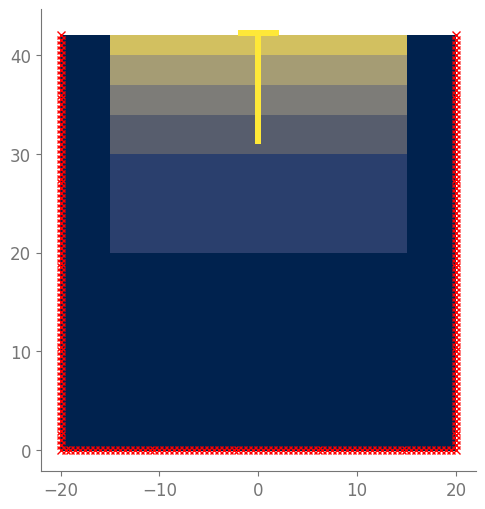

In [8]:
aux.deformacionFill(nodes , elements , UC , factor = 1.0 , cmap='cividis')

A continuación se calculan las tensiones principales y cortantes máximos que serán comparadas con los valores de resistencia a compresión y corte.

In [9]:
sig_1, sig_2, dir_1, dir_2 = pos.principal_dirs(S_nodes)
TAO = (np.abs(sig_1 - sig_2))/2

Incialmente se visualiza  la tensión principal máxima en el estrato 1 y el pilote.

(36.0, 45.0)

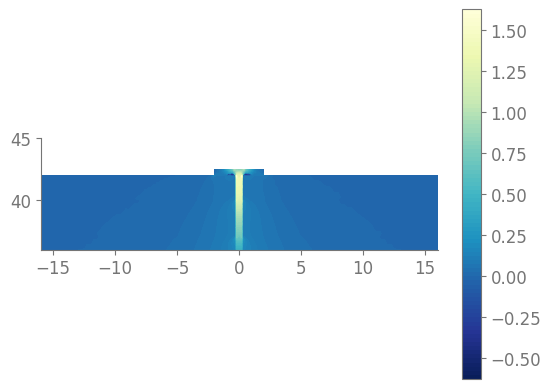

In [10]:
els = np.vstack((
    eles[1],  # Semi-espacio
    eles[2],  # Estrato 5
    eles[3],  # Estrato 4
    eles[4],  # Estrato 3
    eles[5],  # Estrato 2
    eles[6],  # Estrato 1
    eles[7],  # Semi-espacio
    eles[8],  # Semi-espacio
    eles[9],  # Semi-espacio
    eles[10],  # Semi-espacio
    eles[11]   # Cimentación
))
pos.plot_node_field(sig_1, nodes, els, plt_type="contourf", levels=100)
plt.xlim([-16,16])
plt.ylim([36,45]) 

Se resaltan las zonas que superan el valor de referencia (resistencia a la compresión del primer estrato) color  púrpura oscuro. Se verifica que la combinación elegida no supera el valor de referencia en el estrato 1.

(36.0, 45.0)

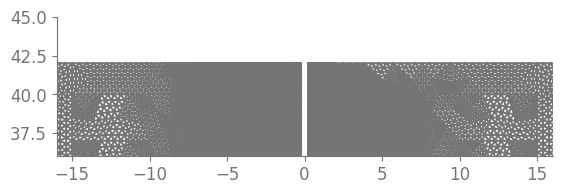

In [11]:
els = np.vstack((
    eles[1],  # Semi-espacio
    eles[2],  # Estrato 5
    eles[3],  # Estrato 4
    eles[4],  # Estrato 3
    eles[5],  # Estrato 2
    eles[6],  # Estrato 1
    eles[7],  # Semi-espacio
    eles[8],  # Semi-espacio
    eles[9],  # Semi-espacio
    #eles[10],  # Semi-espacio
    #eles[11]   # Cimentación
))
ref_val= -9.58
aux.filtered(nodes,els , sig_1, ref_val)
plt.xlim([-16,16])
plt.ylim([36,45])  

De igual forma se verifica que los valores obtenidos para las cargas elegidas no superan los valores de referencia de los demas estratos que son mayores al del estrato 1. 

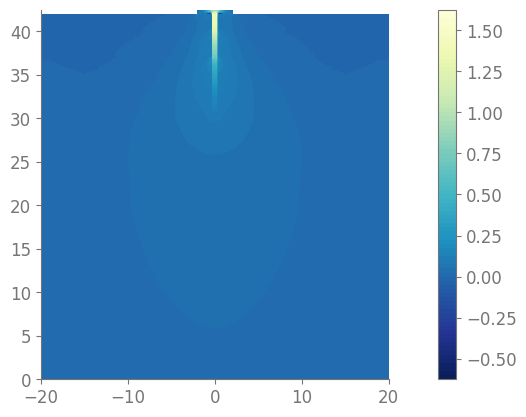

In [12]:
els = np.vstack((
    eles[1],  # Semi-espacio
    eles[2],  # Estrato 5
    eles[3],  # Estrato 4
    eles[4],  # Estrato 3
    eles[5],  # Estrato 2
    eles[6],  # Estrato 1
    eles[7],  # Semi-espacio
    eles[8],  # Semi-espacio
    eles[9],  # Semi-espacio
    eles[10],  # Semi-espacio
    eles[11]   # Cimentación
))
pos.plot_node_field(sig_1, nodes, els, plt_type="contourf", levels=100)


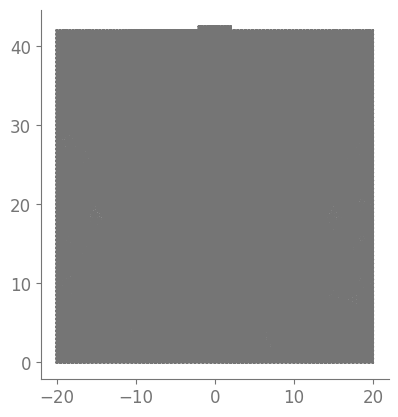

In [13]:
aux.filtered(nodes,els , sig_1, ref_val)


También se visualiza la tensión cortante máxima en el estrato 1 y en el pilote.

(36.0, 45.0)

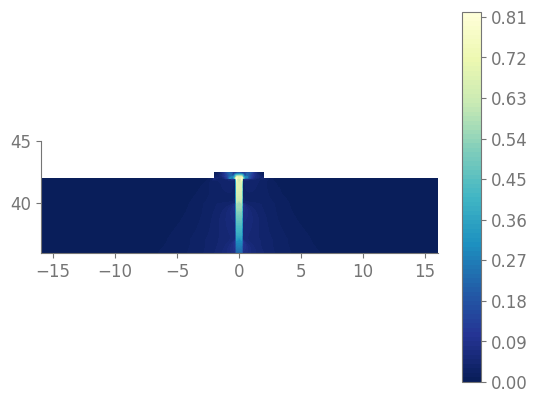

In [14]:
pos.plot_node_field(TAO, nodes, els, plt_type="contourf", levels=100)
plt.xlim([-16,16])
plt.ylim([36,45]) 

Se resaltan las zonas que superan el valor de referencia (resistencia a la tensión cortante del primer estrato) color  púrpura oscuro. Se verifica que la combinación elegida no supera el valor de referencia en el estrato 1.

(36.0, 45.0)

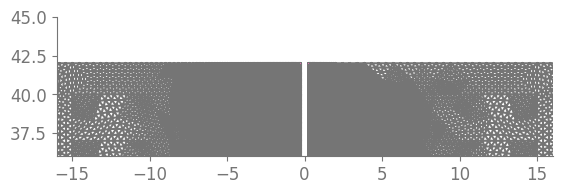

In [15]:
els = np.vstack((
    eles[1],  # Semi-espacio
    eles[2],  # Estrato 5
    eles[3],  # Estrato 4
    eles[4],  # Estrato 3
    eles[5],  # Estrato 2
    eles[6],  # Estrato 1
    eles[7],  # Semi-espacio
    eles[8],  # Semi-espacio
    eles[9],  # Semi-espacio
    #eles[10],  # Semi-espacio
    #eles[11]   # Cimentación
))
ref_val= 0.5
aux.filtered(nodes,els , TAO, ref_val)
plt.xlim([-16,16])
plt.ylim([36,45]) 

y se verefica de igual forma para los demas estratos.

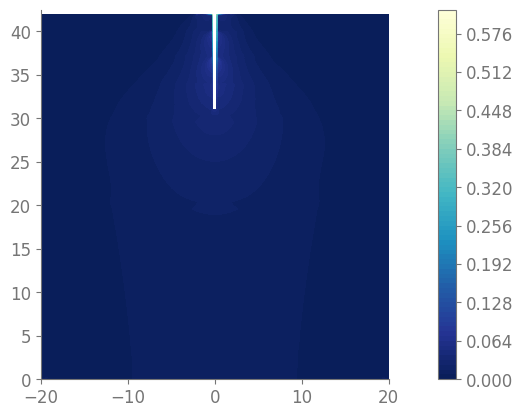

In [16]:
 
pos.plot_node_field(TAO, nodes, els, plt_type="contourf", levels=100)

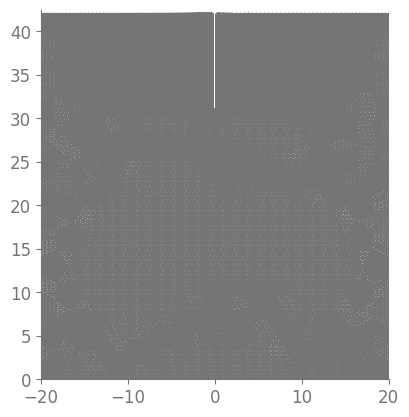

In [17]:
aux.filtered(nodes,els , TAO, ref_val)


Ahora se repite el procedimiento con valores que producen la falla del deposito de suelo al romper el equilibrio del sistema. Para esto se reescalan $\times$ 10  las cargas obtenidas. Se observa como el color purpura alcanza la zona del estrato 1 para la tensión de corte máxima.

La magnitud del vector es: 10.0 tf
P1 = 5.0 tf
P2 = 5.0 tf
V1 = 0.0 tf
V2 = 0.0 tf


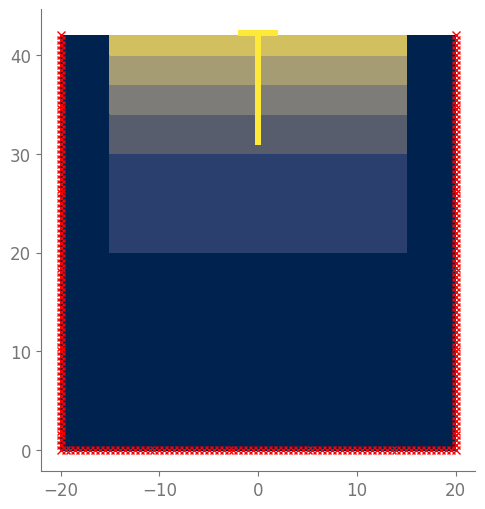

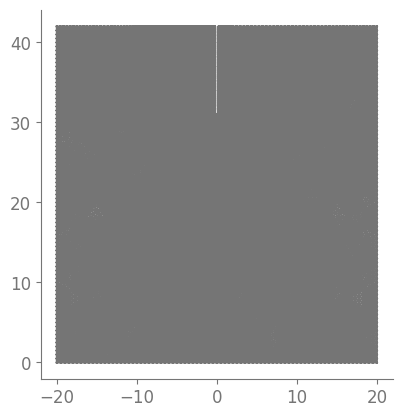

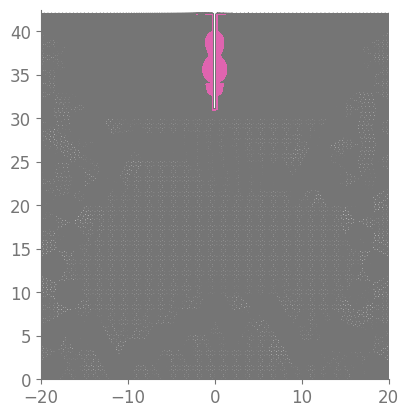

In [18]:
#factor de reescalamiento de las cargas
f_0 = 10

# Define las cargas en tf (tonelada-fuerza) y tf*m (tonelada-fuerza metro)
P = f_0*1.0  # tf
V = f_0*0.0  # tf
M = f_0*0.0  # tf*m

# Calcula la magnitud del vector
magnitud = np.sqrt(P**2 + M**2 + V**2)

# Imprime el resultado
print("La magnitud del vector es:", magnitud, "tf")


# Calcula las cargas resultantes en cada punto de aplicación en tf
P1 = -2 * M + P / 2 # tf
P2 = 2 * M + P / 2 # tf
V1 = V / 2 # tf
V2 = V / 2 # tf

# Imprime las cargas resultantes
print(f"P1 = {P1} tf")
print(f"P2 = {P2} tf")
print(f"V1 = {V1} tf")
print(f"V2 = {V2} tf")


nodes, mats, elements, loads, UG, UC, S_nodes, E_nodes, eles = modelos(P1, P2, V1, V2, id_model)

 
sig_1, sig_2, dir_1, dir_2 = pos.principal_dirs(S_nodes)
TAO = (np.abs(sig_1 - sig_2))/2

aux.deformacionFill(nodes , elements , UC , factor = 1.0 , cmap='cividis')
ref_val = -9.58
aux.filtered(nodes,els , sig_1, ref_val)
ref_val = 0.50
aux.filtered(nodes,els , TAO, ref_val)